# CIFAKE-based model
In this notebook, we will perform various experiments while training a model on the CIFAKE dataset.

CIFAKE contains around 120k images, which can either be real or AI generated. The images have a 32x32 resolution, so it will be interesting to see if our models can capture the patterns correctly even if the resolution is so low.

In [1]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data_utils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib
import torchvision.transforms as transforms
import xai

model_utils.fix_random(42)
TRAINING_MODE=False

In [2]:
# import model to finetune
ft_resnet18 = resnet18(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet18, num_classes=1)
device = model_utils.get_device()
print(f"using {device} device")
ft_resnet18.to(device)

transform_cifake = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB')), # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])        # normalize pixel values
])

LEARNING_RATE = 3e-4
EPOCHS = 10
BATCH_SIZE = 128
DATASET_NAME = "CIFAKE"

using cuda device


In [3]:
train_data = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="train", transform=transform_cifake)
test_data = data_utils.CIFAKEDataset(root_dir="data/CIFAKE", split="test", transform=transform_cifake)

val_data, test_data = data_utils.train_test_split(0.5, dataset=test_data)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True)
dataloaders = (train_dataloader, test_dataloader)

In [4]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(ft_resnet18.fc.parameters(), lr=LEARNING_RATE)

model_name = "CIFAKE_FTResNet18"

In [ ]:
# N.B.: the loss displayed is the testing loss! (not train unless specified)
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet18, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


In [6]:
model_utils.test(test_dataloader, ft_resnet18, loss_fn, device,
                 model_name=model_name)

Test Error:
Accuracy: 75.4%, Avg loss: 0.519401
Confusion matrix report, tp: 3850, fp: 1144, fn: 1319, tn:3687
False
Precision: 0.77, Recall: 0.74, F1-Score: 0.76


(0.5194014491914194, tensor(0.7537, device='cuda:0'))

In [12]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

ResNet50 with AdamW

In [7]:
ft_resnet50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet50, num_classes=1)
ft_resnet50.to(device)

optimizer = torch.optim.AdamW(ft_resnet50.fc.parameters(), lr=LEARNING_RATE)
model_name = "CIFAKE_FTResNet50"

In [ ]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer,
                              ft_resnet50, model_name, BATCH_SIZE,
                              EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:174: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


In [12]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

Test Error:
Accuracy: 82.6%, Avg loss: 0.389056
Confusion matrix report, tp: 4028, fp: 966, fn: 770, tn:4236
False
Precision: 0.81, Recall: 0.84, F1-Score: 0.82


(0.38905610804316365, tensor(0.8264, device='cuda:0'))

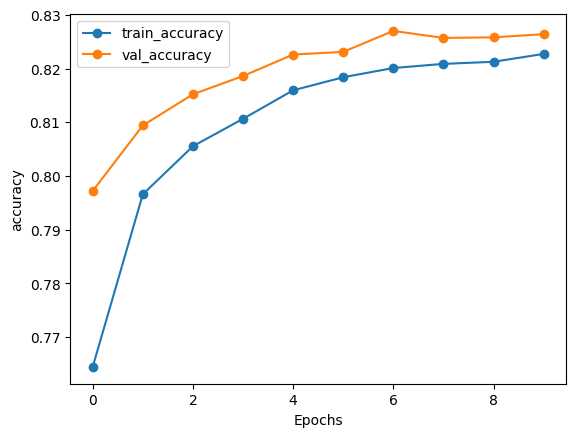

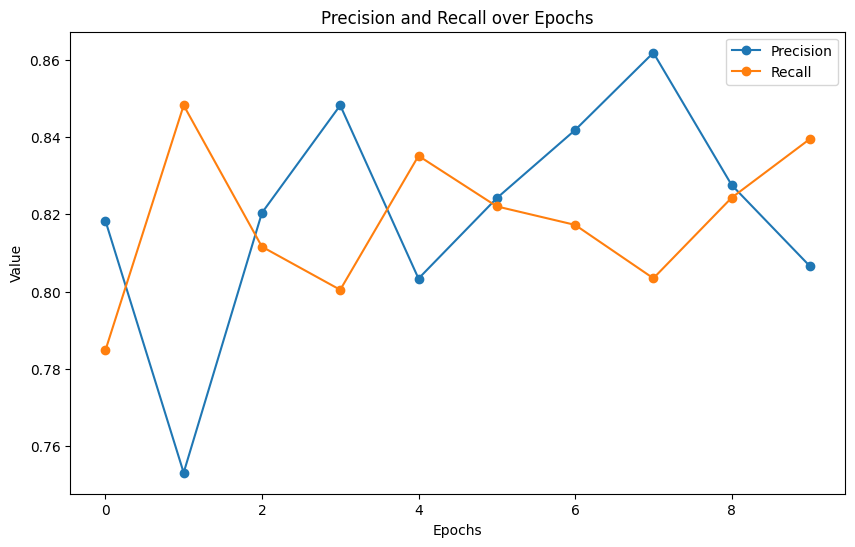

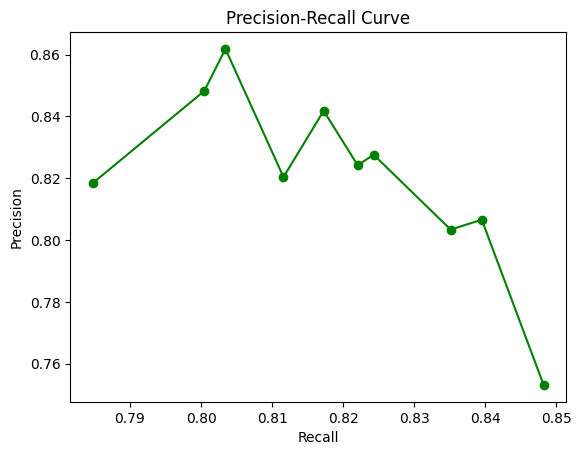

In [ ]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

GradCAM test

In [ ]:
xai.device = device

100%|██████████| 64/64 [00:00<00:00, 87.00it/s]


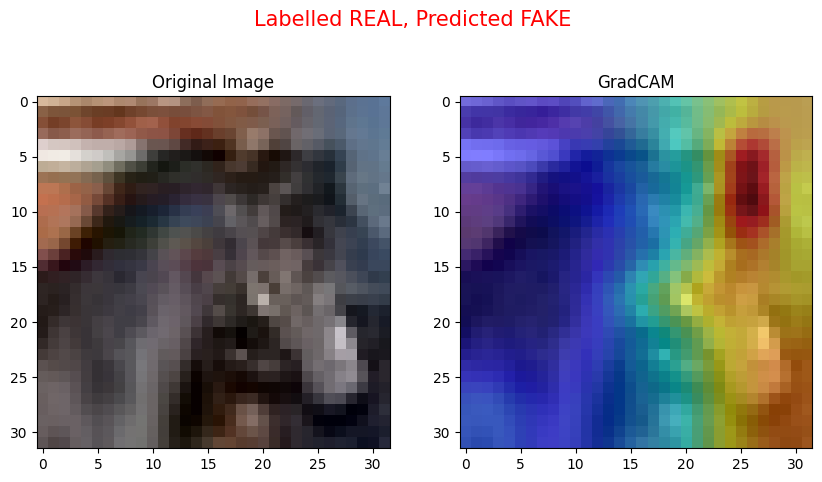

In [7]:
xai.explain_gradcam_single_image(test_dataloader, ft_resnet50, [ft_resnet50.layer1, ft_resnet50.layer2, ft_resnet50.layer3, ft_resnet50.layer4],
                                 model_name=model_name, dataset_name=DATASET_NAME,
                                 index = 2)

100%|██████████| 1000/1000 [00:00<00:00, 1380.99it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


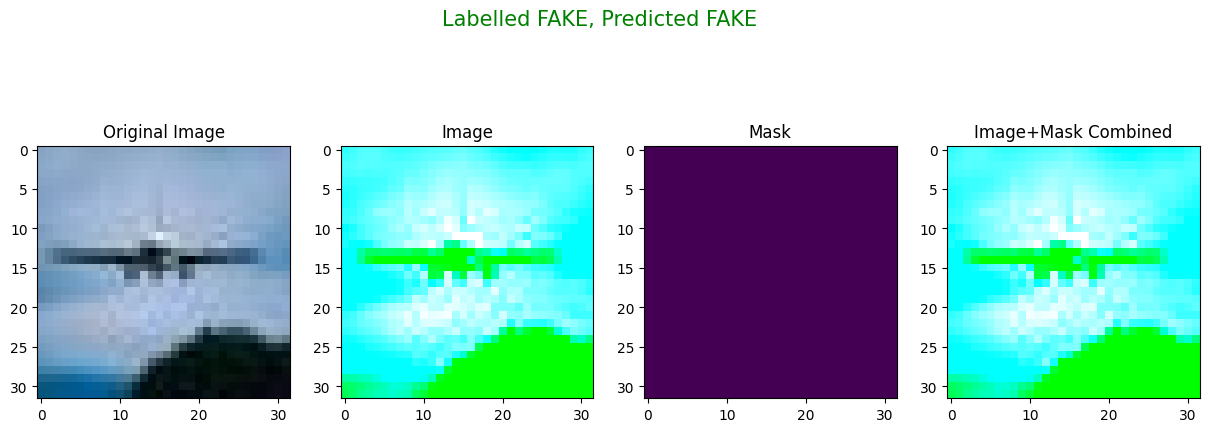

In [10]:
xai.explain_lime_single_image(test_dataloader, ft_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                index = 3)

#### Better finetuning of resnet
The classification head has been already finetuned.
time to finetune the feauture extractor.

In [15]:
for param in ft_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "CIFAKE_FTResNet50_beefy"

In [ ]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.219537, train accuracy: 86.04%  [ 5120/100000]
Training loss: 0.167245, train accuracy: 89.21%  [10240/100000]
Training loss: 0.242626, train accuracy: 90.72%  [15360/100000]
Training loss: 0.184420, train accuracy: 91.59%  [20480/100000]
Training loss: 0.130810, train accuracy: 92.18%  [25600/100000]
Training loss: 0.104722, train accuracy: 92.57%  [30720/100000]
Training loss: 0.103200, train accuracy: 92.99%  [35840/100000]
Training loss: 0.069943, train accuracy: 93.30%  [40960/100000]
Training loss: 0.116271, train accuracy: 93.54%  [46080/100000]
Training loss: 0.145355, train accuracy: 93.74%  [51200/100000]
Training loss: 0.079350, train accuracy: 93.94%  [56320/100000]
Training loss: 0.083442, train accuracy: 94.14%  [61440/100000]
Training loss: 0.089344, train accuracy: 94.33%  [66560/100000]
Training loss: 0.043742, train accuracy: 94.48%  [71680/100000]
Training loss: 0.100245, train accuracy: 94.58%  [76800/10000

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Error:
Accuracy: 97.2%, Avg loss: 0.079453
Confusion matrix report, tp: 4810, fp: 184, fn: 97, tn:4909


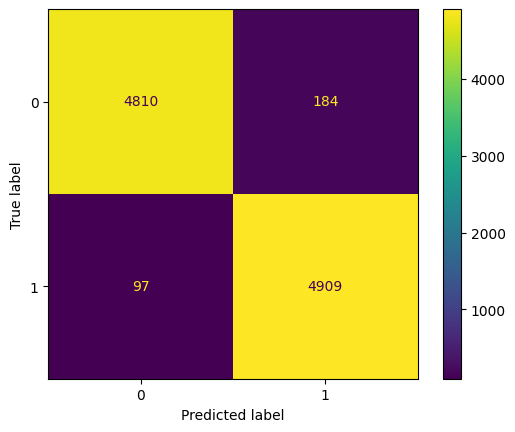

Precision: 0.96, Recall: 0.98, F1-Score: 0.97


(0.0794525704806364, tensor(0.9719, device='cuda:0'))

In [ ]:
model_utils.test(test_dataloader, ft_resnet50, loss_fn, device,
                 model_name=model_name)

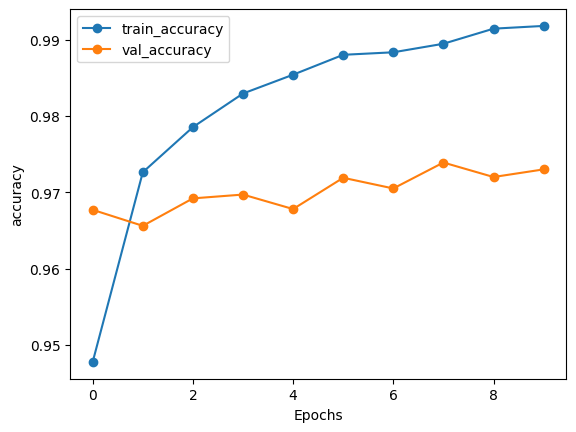

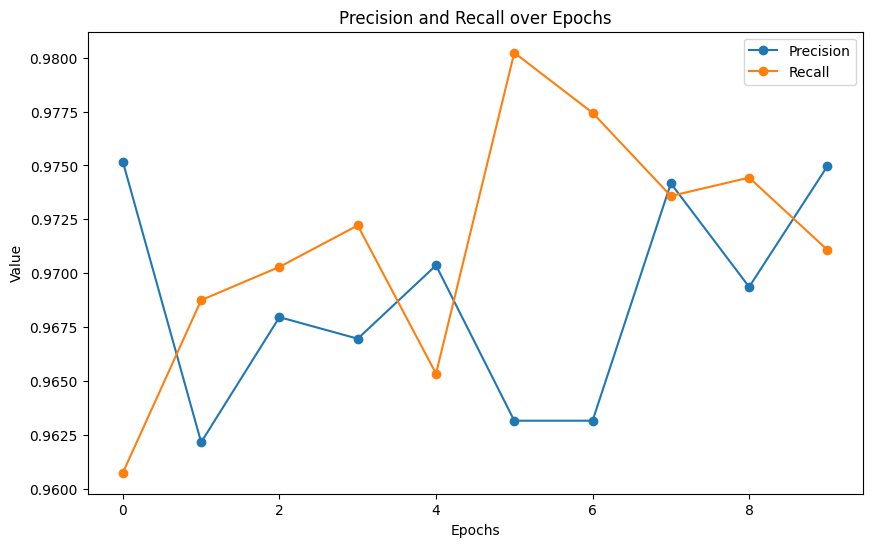

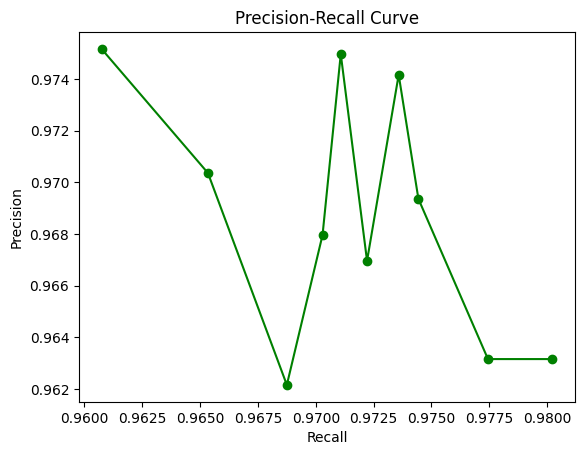

In [18]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

### Modified ResNET (3 LL)

In [19]:
mod_resnet50 = model_utils.ModifiedResNet(original_resnet=resnet50(weights='IMAGENET1K_V1'))

In [20]:
mod_resnet50.prepare_for_ft()
mod_resnet50.to(device)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, mod_resnet50.parameters()), lr=0.001
)

model_name = "CIFAKE_ModResNet50"

In [ ]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, mod_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.490625, train accuracy: 69.90%  [ 5120/100000]
Training loss: 0.493535, train accuracy: 73.46%  [10240/100000]
Training loss: 0.493653, train accuracy: 74.84%  [15360/100000]
Training loss: 0.428566, train accuracy: 75.80%  [20480/100000]
Training loss: 0.397946, train accuracy: 76.20%  [25600/100000]
Training loss: 0.572606, train accuracy: 76.72%  [30720/100000]
Training loss: 0.377920, train accuracy: 77.03%  [35840/100000]
Training loss: 0.444117, train accuracy: 77.40%  [40960/100000]
Training loss: 0.424579, train accuracy: 77.78%  [46080/100000]
Training loss: 0.364456, train accuracy: 78.05%  [51200/100000]
Training loss: 0.349593, train accuracy: 78.31%  [56320/100000]
Training loss: 0.471574, train accuracy: 78.37%  [61440/100000]
Training loss: 0.561542, train accuracy: 78.53%  [66560/100000]
Training loss: 0.395721, train accuracy: 78.67%  [71680/100000]
Training loss: 0.434464, train accuracy: 78.82%  [76800/10000

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Error:
Accuracy: 85.4%, Avg loss: 0.329472
Confusion matrix report, tp: 4219, fp: 775, fn: 683, tn:4323


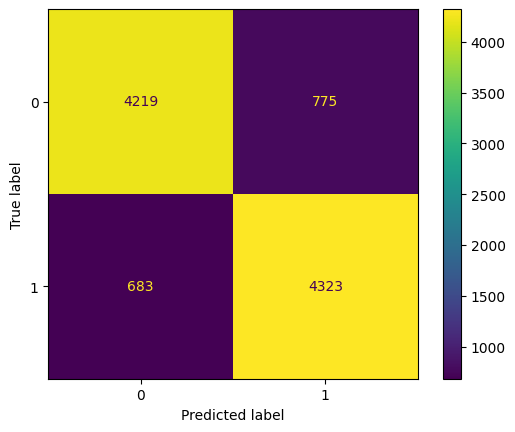

Precision: 0.84, Recall: 0.86, F1-Score: 0.85


(0.3294723492257203, tensor(0.8542, device='cuda:0'))

In [ ]:
model_utils.test(test_dataloader, mod_resnet50, loss_fn, device,
                 model_name=model_name)

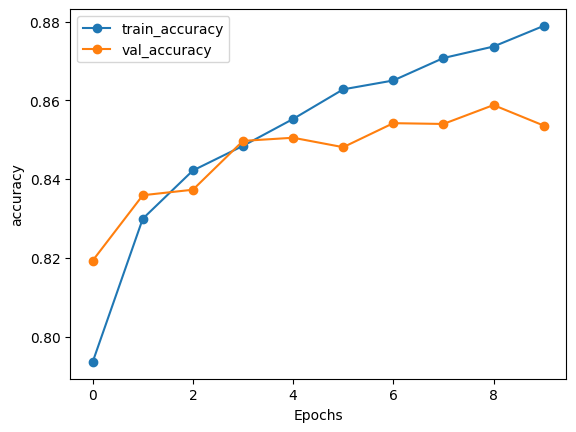

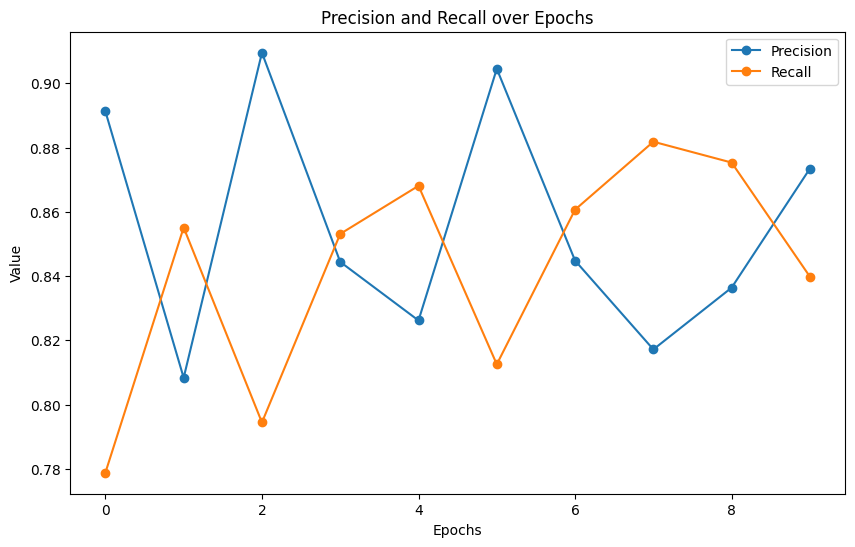

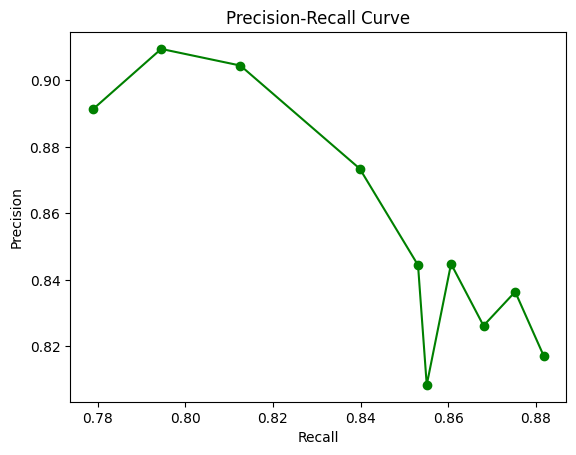

In [23]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

#### Finetune 2 strategy on new model

In [24]:
for param in mod_resnet50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(mod_resnet50.parameters(), lr=LEARNING_RATE)
model_name = "CIFAKE_ModResNet50_beefy"

In [ ]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, mod_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.351507, train accuracy: 86.21%  [ 5120/100000]
Training loss: 0.160543, train accuracy: 89.13%  [10240/100000]
Training loss: 0.149678, train accuracy: 90.36%  [15360/100000]
Training loss: 0.120412, train accuracy: 91.34%  [20480/100000]
Training loss: 0.179741, train accuracy: 92.03%  [25600/100000]
Training loss: 0.127513, train accuracy: 92.50%  [30720/100000]
Training loss: 0.094612, train accuracy: 92.89%  [35840/100000]
Training loss: 0.138682, train accuracy: 93.19%  [40960/100000]
Training loss: 0.092044, train accuracy: 93.44%  [46080/100000]
Training loss: 0.067447, train accuracy: 93.68%  [51200/100000]
Training loss: 0.093121, train accuracy: 93.91%  [56320/100000]
Training loss: 0.143256, train accuracy: 94.03%  [61440/100000]
Training loss: 0.104806, train accuracy: 94.19%  [66560/100000]
Training loss: 0.052135, train accuracy: 94.32%  [71680/100000]
Training loss: 0.208758, train accuracy: 94.44%  [76800/10000

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Error:
Accuracy: 97.0%, Avg loss: 0.081055
Confusion matrix report, tp: 4826, fp: 168, fn: 129, tn:4877


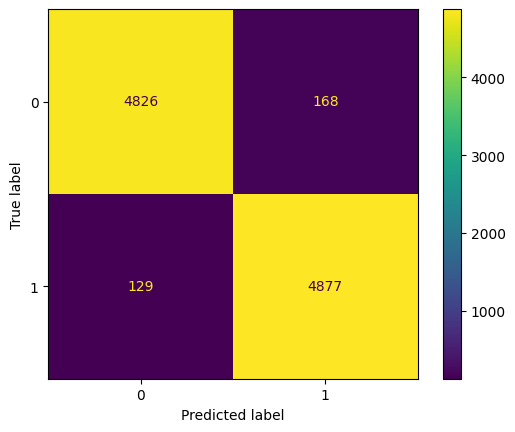

Precision: 0.97, Recall: 0.97, F1-Score: 0.97


(0.08105466807190376, tensor(0.9703, device='cuda:0'))

In [ ]:
model_utils.test(test_dataloader, mod_resnet50, loss_fn, device,
                 model_name=model_name)

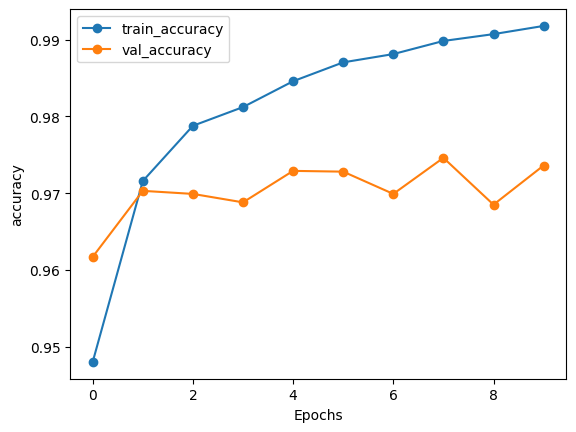

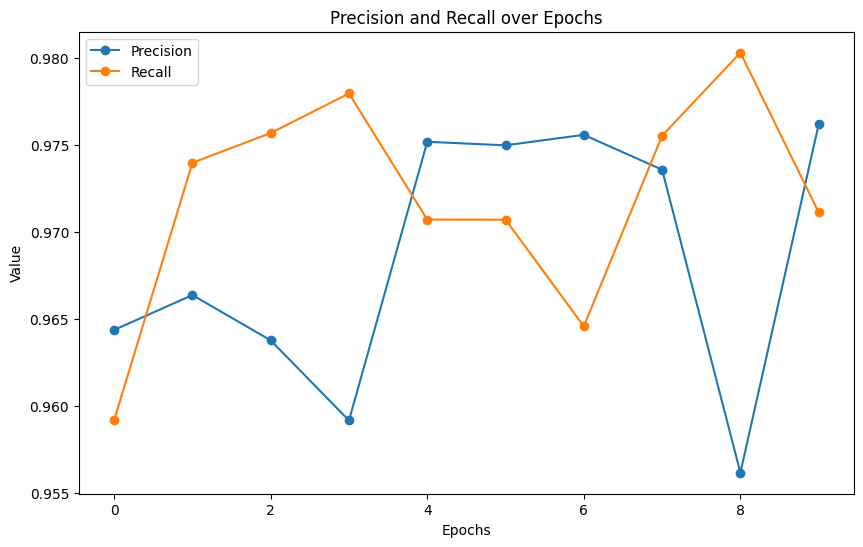

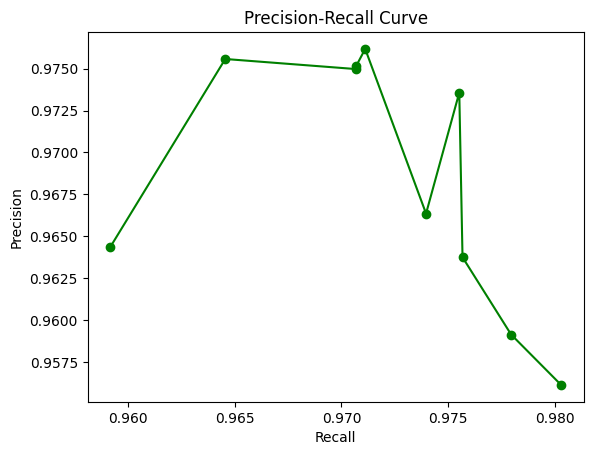

In [27]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

In [4]:
mod_resnet50 = model_utils.ModifiedResNet(original_resnet=resnet50(weights='IMAGENET1K_V1'))
mod_resnet50.to(device)
mod_resnet50.load_state_dict(torch.load("checkpoints/best_ModResNet50_beefy.pth"))
model_name = "ModResNet50_beefy"

100%|██████████| 64/64 [00:00<00:00, 74.67it/s] 


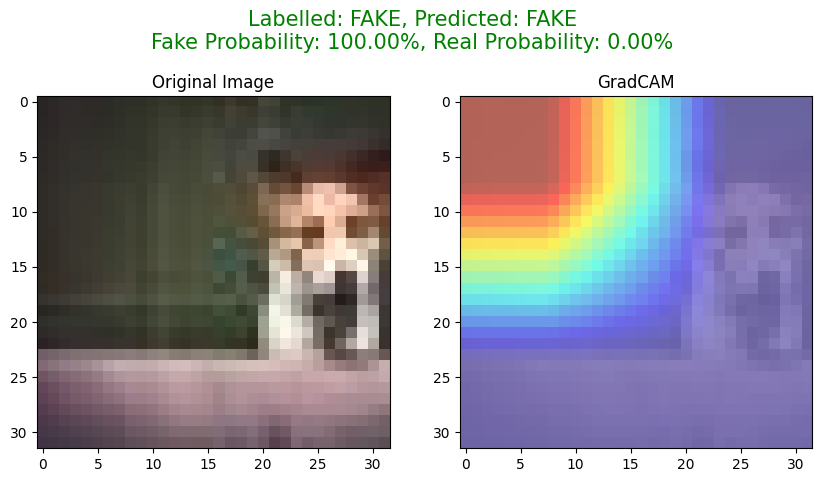

In [5]:
importlib.reload(xai)

target_layers = [mod_resnet50.resnet[6], mod_resnet50.resnet[7]]

xai.explain_gradcam_single_image(test_dataloader, mod_resnet50, target_layers,
                                 model_name=model_name, dataset_name=DATASET_NAME,
                                 index = 15)

In [6]:
importlib.reload(xai)

xai.explain_gradcam_batch(test_dataloader, test_dataloader.batch_size, mod_resnet50, target_layers)

100%|██████████| 64/64 [00:00<00:00, 81.84it/s] 


Visualized batch #1!


100%|██████████| 1000/1000 [00:00<00:00, 1081.01it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


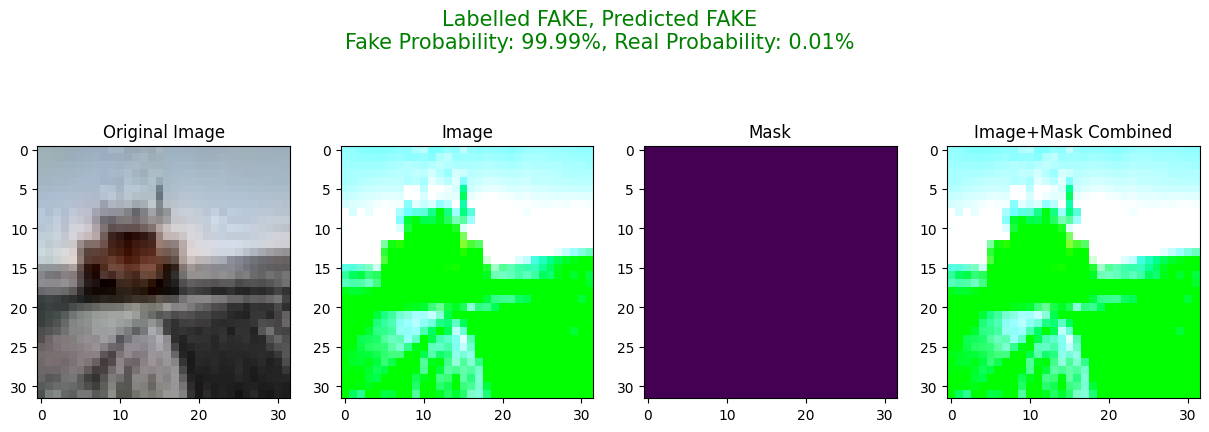

In [33]:
xai.explain_lime_single_image(test_dataloader, mod_resnet50,
                                model_name=model_name, dataset_name=DATASET_NAME,
                                index = 127)

### Dropout experiment

In [28]:
dp_mod_resnet50 = model_utils.ModifiedResNet(original_resnet=resnet50(weights='IMAGENET1K_V1'))
dp_mod_resnet50.prepare_for_ft()
dp_mod_resnet50.to(device)

optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, dp_mod_resnet50.parameters()), lr=0.001
)

model_name = "CIFAKE_ModResNet50_dropout"

In [ ]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, dp_mod_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.506652, train accuracy: 63.81%  [ 5120/100000]
Training loss: 0.447368, train accuracy: 70.11%  [10240/100000]
Training loss: 0.453353, train accuracy: 72.14%  [15360/100000]
Training loss: 0.452628, train accuracy: 73.66%  [20480/100000]
Training loss: 0.471557, train accuracy: 74.59%  [25600/100000]
Training loss: 0.366229, train accuracy: 75.40%  [30720/100000]
Training loss: 0.420633, train accuracy: 76.01%  [35840/100000]
Training loss: 0.421545, train accuracy: 76.42%  [40960/100000]
Training loss: 0.405900, train accuracy: 76.88%  [46080/100000]
Training loss: 0.384687, train accuracy: 77.11%  [51200/100000]
Training loss: 0.457194, train accuracy: 77.37%  [56320/100000]
Training loss: 0.383890, train accuracy: 77.58%  [61440/100000]
Training loss: 0.391021, train accuracy: 77.82%  [66560/100000]
Training loss: 0.426616, train accuracy: 78.06%  [71680/100000]
Training loss: 0.465775, train accuracy: 78.28%  [76800/10000

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Error:
Accuracy: 85.8%, Avg loss: 0.330044
Confusion matrix report, tp: 4235, fp: 759, fn: 661, tn:4345


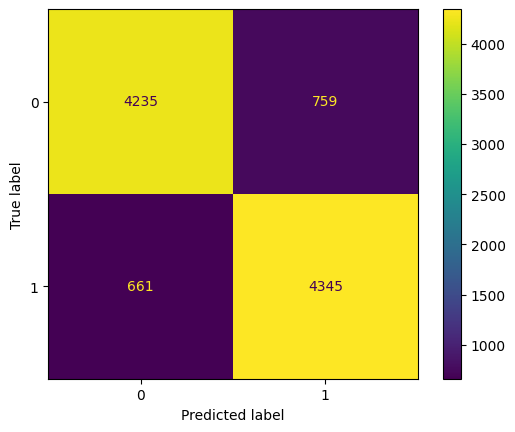

Precision: 0.85, Recall: 0.86, F1-Score: 0.86


(0.3300439460745341, tensor(0.8580, device='cuda:0'))

In [ ]:
model_utils.test(test_dataloader, dp_mod_resnet50, loss_fn, device,
                 model_name=model_name)

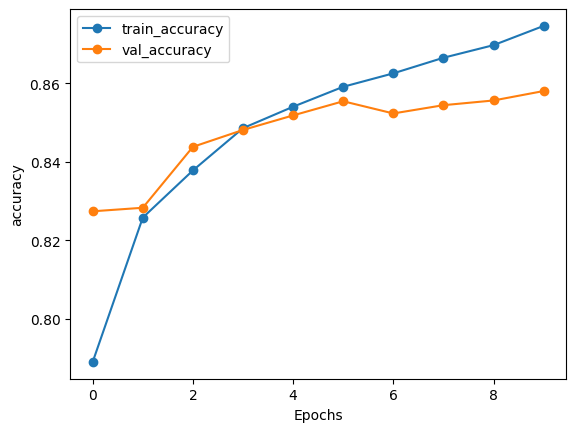

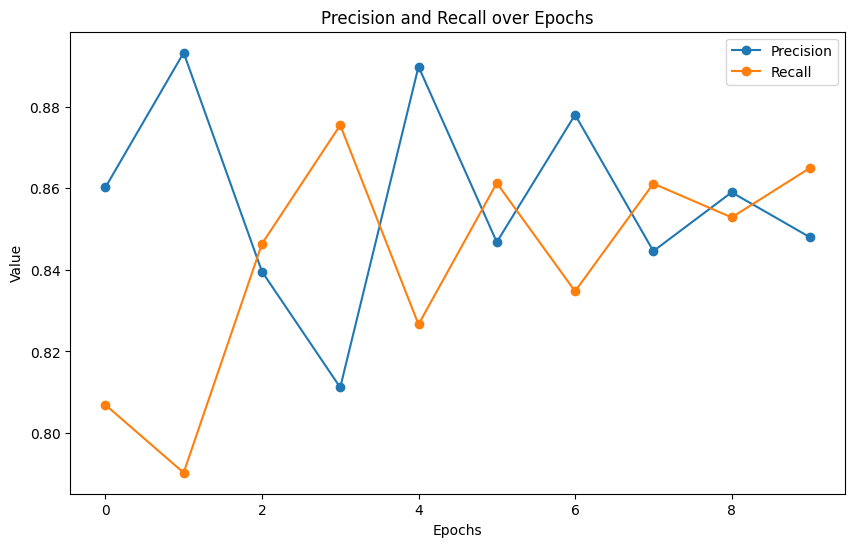

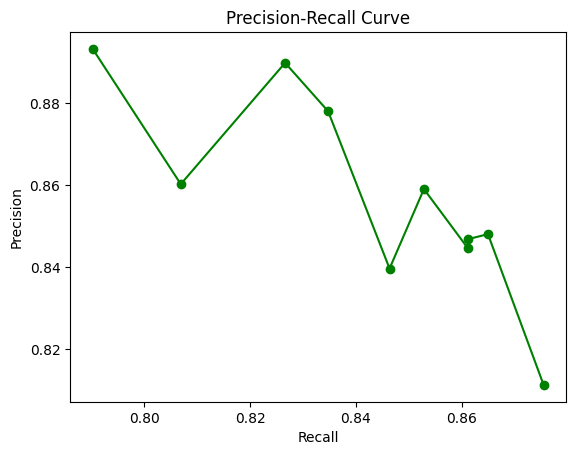

In [31]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)

#### FT2 with dropout experiment

In [32]:
for param in dp_mod_resnet50.parameters():
    param.requires_grad = True

optimizer = torch.optim.AdamW(dp_mod_resnet50.parameters(), lr=0.001)

model_name = "CIFAKE_ModResNet50_dropout_beefy"

In [ ]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, dp_mod_resnet50, model_name, BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=TRAINING_MODE)

Epoch 1/10
-------------------------------
Training loss: 0.269506, train accuracy: 84.82%  [ 5120/100000]
Training loss: 0.188949, train accuracy: 88.00%  [10240/100000]
Training loss: 0.188751, train accuracy: 89.50%  [15360/100000]
Training loss: 0.200153, train accuracy: 90.32%  [20480/100000]
Training loss: 0.084579, train accuracy: 90.93%  [25600/100000]
Training loss: 0.098530, train accuracy: 91.42%  [30720/100000]
Training loss: 0.200508, train accuracy: 91.82%  [35840/100000]
Training loss: 0.146602, train accuracy: 92.10%  [40960/100000]
Training loss: 0.194661, train accuracy: 92.26%  [46080/100000]
Training loss: 0.179730, train accuracy: 92.46%  [51200/100000]
Training loss: 0.102400, train accuracy: 92.66%  [56320/100000]
Training loss: 0.157261, train accuracy: 92.84%  [61440/100000]
Training loss: 0.149876, train accuracy: 92.99%  [66560/100000]
Training loss: 0.112903, train accuracy: 93.10%  [71680/100000]
Training loss: 0.141675, train accuracy: 93.19%  [76800/10000

c:\Users\tekke\Desktop\ethics_project2\model_utils.py:161: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_path))


Test Error:
Accuracy: 96.4%, Avg loss: 0.094446
Confusion matrix report, tp: 4754, fp: 240, fn: 118, tn:4888


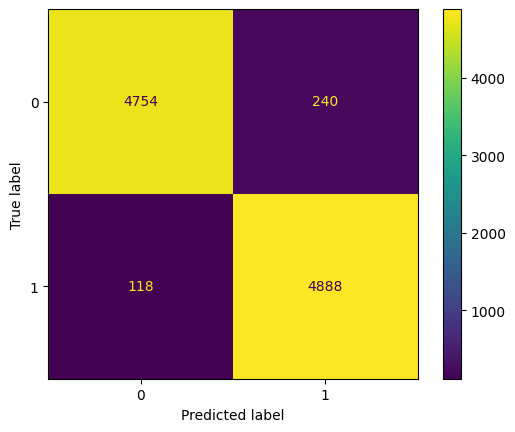

Precision: 0.95, Recall: 0.98, F1-Score: 0.96


(0.0944462557665155, tensor(0.9642, device='cuda:0'))

In [ ]:
model_utils.test(test_dataloader, dp_mod_resnet50, loss_fn, device,
                 model_name=model_name)

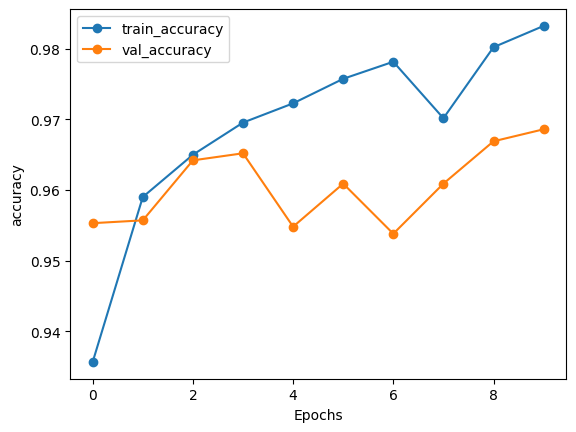

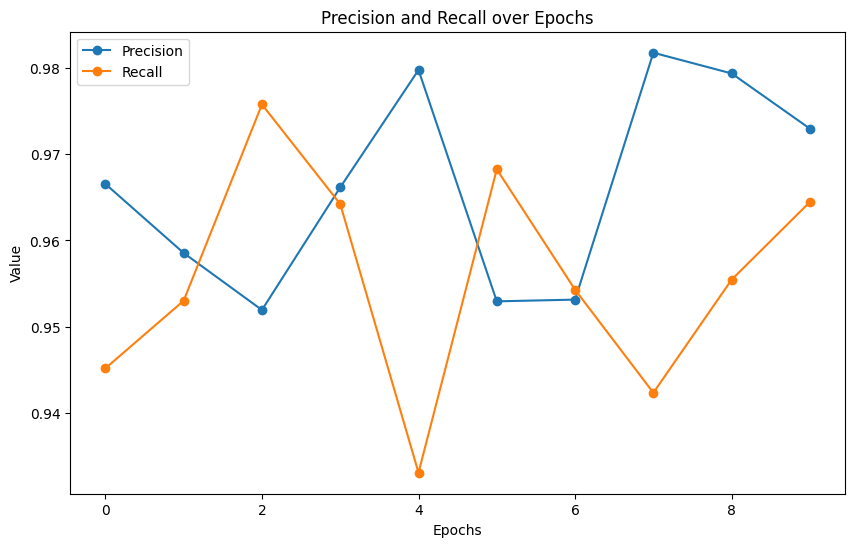

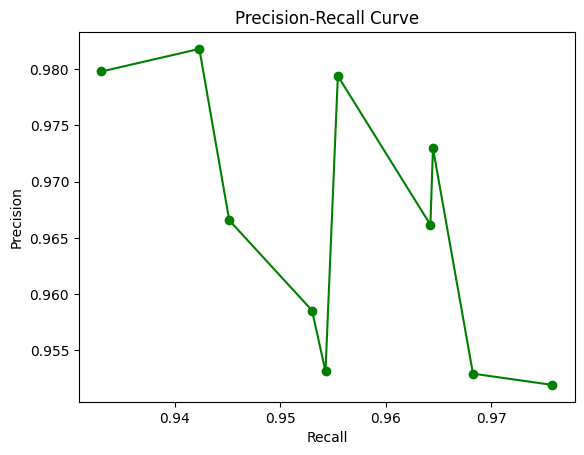

In [35]:
if artifacts != None:
    losses, train_accs, test_accs, precisions, recalls = artifacts
    plotter.plot_generic_metrics((train_accs, test_accs), "accuracy", model_name)
    plotter.plot_precision_recall_curve(precisions, recalls, model_name)